# 트랜스포머 확장

- AI 연구 분야의 **쓰라린 교훈(bitter lesson)**
    - 2019년 리처드 서튼(Richard Sutton)박사
        - 앨버타 대학교의 컴퓨터 과학과 교수이자 같은 대학에서 강화학습 및 인공지능 분과의 AITF(Alberta Innovates Technology Future) 의장을 맡고 있다. 또한, 딥마인드의 우수 과학자(Distinguished Research Scientist)이기도 하다.
    - 계산량을 활용하는 일반적인 방법이 도메인 지식을 활용하는 방안을 압도한다.
    - 생각으로 구축한 방법은 장기적으료 효과를 내지 못한다.
    - 체스나 바둑과 같은 사례에서 확인 가능
    
<img src="http://incompleteideas.net/sutton-head12.jpg" width=200>    

In [1]:
model_data = [
    {'date': '12-06-2017', 'name': 'Transformer', 'size': 213*1e6},
    {'date': '11-06-2018', 'name': 'GPT', 'size': 110*1e6},
    {'date': '11-10-2018', 'name': 'BERT', 'size': 340*1e6},
    {'date': '14-02-2019', 'name': 'GPT-2', 'size': 1.5*1e9},
    {'date': '23-10-2019', 'name': 'T5', 'size': 11*1e9},
    {'date': '17-09-2019', 'name': 'Megatron', 'size': 8.3*1e9},
    {'date': '13-02-2020', 'name': 'Turing-NLG', 'size': 17*1e9},
    {'date': '30-06-2020', 'name': 'GShard', 'size': 600*1e9},
    {'date': '28-05-2020', 'name': 'GPT-3', 'size': 175*1e9},
    {'date': '11-01-2021', 'name': 'Switch-C', 'size': 1.571*10e12},
]

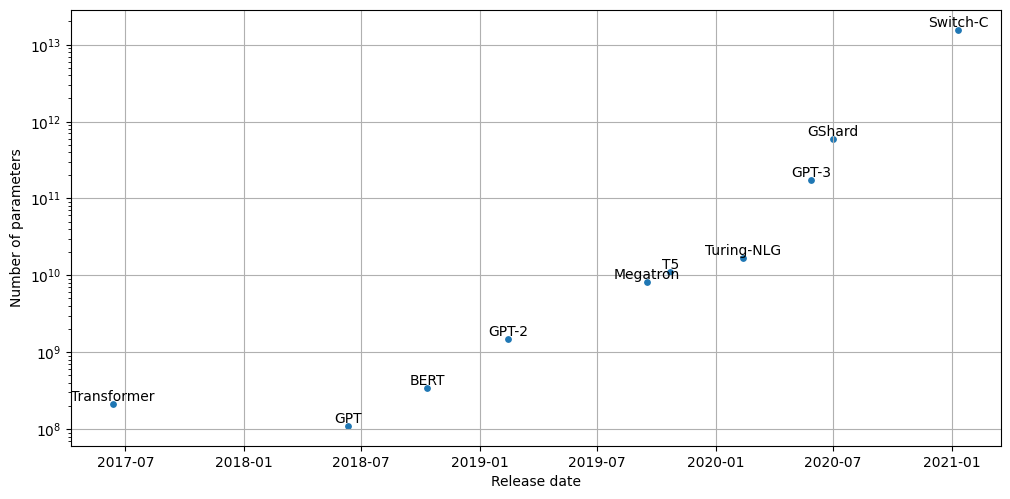

In [2]:
# 중요 트랜스포머 아키텍처의 파라미터 개수
import pandas as pd
import matplotlib.pyplot as plt

def label_point(x, y, val, ax):
    a = pd.concat({"x": x, "y": y, "val": val}, axis=1)
    for i, point in a.iterrows():
        ax.text(
            point["x"],
            point["y"],
            str(point["val"]),
            horizontalalignment="center",
            verticalalignment="bottom",
        )


df_lm = pd.DataFrame.from_records(model_data)
df_lm["date"] = pd.to_datetime(df_lm["date"], dayfirst=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
df_lm.plot(x="date", y="size", kind="scatter", s=15, ax=ax)
ax.set_yscale("log")
label_point(df_lm["date"], df_lm["size"], df_lm["name"], ax)
ax.set_xlabel("Release date")
ax.set_ylabel("Number of parameters")
ax.grid(True)
plt.subplots_adjust(top=1.2)
plt.show()

- 이런 교훈이 트랜스포머에 적용되고 있다.
- BERT나 GPT를 계승한 초기 모델은 주로 구조나 사전 훈련 조정
- 2021년 중반 최고 성능을 보인 GPT-3는 근본적인 구조의 큰 변경 없이 모델 확장
- 수년만에 모델의 크기의 자릿수가 네 개나 늘어남
- 대규모 언어 모델이, 후속 작업에 더 유리, 제로샷 학습과 퓨샷 학습 같은 흥미로운 기능은 10~100억 개 파라미터 범위 내에서 잘동작 한다는 사실이 경험적으로 밝혀짐
- 이를 위해선 계산량과 훈련 파라미터도 확장 되어야 함
- GPT-3 학습에 460만 달러 필요 예상 
- 언어 모델 성능은 모델 크기 및 그 외 요소와 관련된 거듭제곱 법칙을 따른다.

## 규모의 법칙

- 컴퓨팅 예산 (C), 데이터셋 크기 (D), 모델 크기 (N)에 따른 언어 모델의 Test loss 비교
- 클수록 좋다

### 성능과 규모의 관계
- 일반적으로, 개발자는 고정된 데이터셋에서 성능을 향상 시키기 위해 구조 변경이나 하이퍼파라미터 튜닝을 시도한다.
- 그러나 규모의 법칙에 따르면, N, C, D를 동시에 증가 시키는 것이 더 나은 모델을 만드는데 생산적이다.

### 거듭제곱 법칙
- 테스트 손실 (L)은 N, C, D와 여러 자릿수에서 거듭제곱 관계(로그 스케일에서 선형)
- X = M, C, D 일떄, 이 거듭제곱의 관계는 $L(X) \sim \frac{1}{X^\alpha}$
- $\alpha$는 0.05~0.0095 
- 손실 곡선의 초기 부분 곡선을 연창해서 훈련을 더 오래 수행할 때 얻게  될 손실의 근사치 추정 가능

<img alt="scaling-laws" caption="Power-law scaling of test loss versus compute budget (left), dataset size (middle), and model size (right) (courtesy of Jared Kaplan)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter11_scaling.png?raw=1" id="scaling-laws"/>

### 샘플 효율성
- 대규모 모델은 더 적은 횟수의 훈련 단계로 소규모 모델과 동일한 성능
- 일정 횟수 후의 훈련 단계를 거친 후 손실 곡선이 평탄화 짐
- 단순히 모델을 확장한 것에 비해 성능 계선이 크지 않음

- 다양한 분야에서도 거듭제곱의 법칙이 관찰 됨
- 훈련 비용이 많이 드는 대규모 모델을 훈련 시키지 않고도 성능을 예측 하는 도구로 활용

<img alt="scaling-laws-modal" caption="Power law scaling of test loss versus compute budget across a wide range of modalities (courtesy of Tom Henighan)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter11_scaling-modal.png?raw=1" id="scaling-laws-modal"/>

## 규모 확장의 어려움

- **인프라** : 대규모 분산 실험을 필요한 구조와 전문 엔지니어 필요
- **비용** : 클라우드에서 최신 GPU은 운영 시간 = 막대한 비용
- **데이터셋 큐레이션** : 대규모 데이터의 전처리, 편향 제거(성차별, 인종 차별 등), 개인정보 제거 등은 쉽지 않다.
- **모델 평가** : 모델이 편향되어 있거나 유해 하지 않는지 검증 필요
- **배포** : 대규모 언어 모델을 서빙 하는 것도 큰 도전 임

- 참고 단체
    - **BigScience** : 대규모 언어모델에 초점을 둔 연구 워크샵
    - **EleutherAI** : GPT-3 크기의 모델을 훈련하고 오픈소스로 공개 목적의 단체, https://eleuther.ai

### 어텐션 플리즈!
- 셀프 어텐션
    - 시퀀스에 있는 모든 토큰의 쌍을 비교, 가중치 생성
    - 긴 문서나 음성, 컴퓨터 비전에 적용시 계산의 병목 지점이 됨
    - 계산 복잡도 : $n^2$, $n$ 은 시퀀스 길이
    
<img src='./nlp-with-transformers-main/images/fig_11_04.png' width=500>   

- 어텐션 메커니즘 효율과 관련 연구들
    - 희소성을 추가 하거나, 어텐션 행렬에 커널을 적용, 효율적으로 어텐션을 만들려고 하는 시도가 주류

## 희소 어텐션
- 셀프 어텐션 층에서 수행되는 계산의 횟수를 줄이기 위해, 미리 정의된 패턴을 따라 생성되는 쿼리-키 쌍의 개수를 제한 한다.

<img alt="Atomic sparsity patterns" caption="Common atomic sparse attention patterns for self-attention: a colored square means the  attention score is calculated, while a blank square means the score is discarded (courtesy of Tianyang Lin)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter11_atomic-sparse-attention.png?raw=1" id="sparsity-atomic"/>

- **글로벌 어텐션** : 시퀀스에서 다른 모든 토큰의 주의를 기울이는 몇개의 특수한 토큰을 정의
- **밴드 어텐션** : 대각선에 걸친 어텐션 계산
- **팽창 어텐션** : 간격을 준 팽찬 윈도우를 사용한 일부 쿼리-키 쌍을 건너뜀
- **랜덤 어텐션** : 쿼리마다 몇 개의 키를 랜덤하게 샘플링
- **블록 로컬 어텐션** : 시퀀스를 블록으로 나누고, 이 블록 안에서 어텐션 점수 계산

<img alt="Attention with compound sparsity" caption="Sparse attention patterns for recent transformer models (courtesy of Tianyang Lin)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter11_compound-sparse-attention.png?raw=1" id="sparsity-compound"/>

## 선형 어텐션
- 전통적인 셀프 어텐션은 계산 비용이 높다, 왜냐하면 각 단어가 문장의 모든 단어와의 관계를 계산해야 하기 때문
    - 특히 긴 문장에서는 매우 비효율적
- 선형 셀프 어텐션은 계산을 단순화하고 속도를 높이기 위해, 유사도 함수를 두 부분으로 나누는 커널 함수로 표현
    - 커널 함수는 **원래 데이터를 고차원 특성 공간으로 매핑하여, 복잡한 비선형 관계를 선형적으로 해석 가능하게** 만든다
    - 선형 셀프 어텐션의 경우, 커널 함수를 사용하여 쿼리와 키 간의 내적 계산을 간소화하고, 이를 통해 속도를 높이며 계산 비용을 절감

<img alt="Linear attention" caption="Complexity difference between standard self-attention and linearized self-attention (courtesy of Tianyang Lin)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter11_linear-attention.png?raw=1" id="linear-attention"/>

# 텍스트를 넘어서

## 비전

**iGPT**
- Image GPT의 약자
- 이미지를 픽셀의 시퀀스로 간주, GPT 아이텍처와 자기회귀 사전 훈련 목표를 사용, 다음 픽셀 값을 예측

<img alt="iGPT" width="800" caption="Examples of image completions with iGPT (courtesy of Mark Chen)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter11_iGPT.png?raw=1" id="iGPT"/>

**ViT**
- ViT(비전 트랜스포머)는 비전을 위해 트랜스포머를 선택한 BERT 스타일의 모델 
- 이미지를 작은 패치로 분할, 각 패치를 선형 투영을 통해 임베딩
    - BERT 토큰 임베딩과 유사
- 패치 임베딩을 위치 임베딩과 연결, 트랜스포머 인코더에 주입
- 목표는 마스킹 된 패치의 평균 컬러 예측
- 대규모의 데이터셋에서 CNN보다 더 좋은 확장성
    - 비디오 모델로 확장 가능

<img alt="vit-architecture" width="800" caption="The ViT architecture (courtesy of Alexey Dosovitskiy et al.)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter11_vit-architecture.png?raw=1" id="vit-architecture"/>

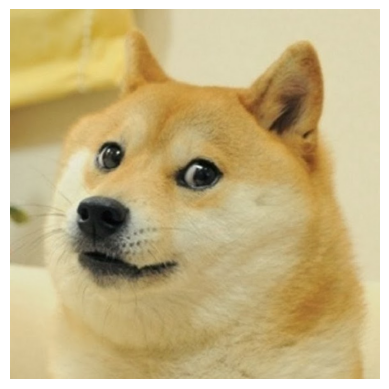

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open("./nlp-with-transformers-main/images/doge.jpg")
plt.imshow(image)
plt.axis("off")
plt.show()

In [4]:
import pandas as pd
from transformers import pipeline

image_classifier = pipeline("image-classification")
preds = image_classifier(image)
preds_df = pd.DataFrame(preds)
preds_df

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 5dca96d (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.


,score,label
0,0.643600,"Eskimo dog, husky"
1,0.207406,Siberian husky
2,0.060160,"dingo, warrigal, warragal, Canis dingo"
3,0.035359,"Norwegian elkhound, elkhound"
4,0.012927,"malamute, malemute, Alaskan malamute"


## 테이블
- 고객 데이터는 테이블 형태로 저장되어 있음, 자연어로 테이블에 쿼리를 날리는 방법은?
- TAPAS (Table Parser for Question Answering)는 Google Research에 의해 개발된, 자연어 질문에 답하기 위해 테이블 형태의 데이터를 이해하고 해석하는 능력을 갖춘 모델입니다. 이 모델은 테이블과 텍스트 데이터를 동시에 처리하여 질문에 대한 정확한 답변을 찾아내는 데 사용됩니다.

<img alt="table-qa" width="800" caption="Question answering over a table (courtesy of Jonathan Herzig)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter11_table-qa.png?raw=1" id="tapas-table"/>

**TAPAS의 주요 특징**

1. **BERT 기반**: TAPAS는 구글이 개발한 BERT 모델을 기반으로 합니다. BERT는 다양한 언어 이해 작업에 강력한 성능을 보이는 딥러닝 모델로, 문맥에 따라 단어의 의미를 파악할 수 있습니다. TAPAS는 이 기술을 활용해 테이블의 구조와 내용을 이해합니다.

2. **테이블 구조 인식**: TAPAS는 테이블의 행과 열을 인식하고, 각 셀이 어떻게 서로 관련되어 있는지를 파악합니다. 이는 테이블 내에서 데이터의 관계와 패턴을 찾아내는 데 중요한 역할을 합니다.

3. **질문 이해**: 사용자가 제시한 자연어 질문을 분석하여, 질문의 의도와 필요한 정보를 파악합니다.

**작동 원리**

1. **입력 전처리**: 입력으로 주어진 테이블 데이터는 토큰화되어 각 셀의 내용이 개별 토큰으로 분리됩니다. 이때, 테이블의 행과 열 정보도 함께 모델에 입력됩니다. 질문 역시 토큰화되어 입력됩니다.

2. **모델 처리**: BERT 기반의 아키텍처를 사용하여, 입력된 테이블 데이터와 질문을 동시에 처리합니다. 모델은 테이블의 구조와 질문 사이의 관계를 이해하고, 어떤 셀이 질문에 관련되어 있는지를 결정합니다.

3. **답변 생성**: 질문 유형에 따라, TAPAS는 다음과 같이 답변을 생성할 수 있습니다.
   - **셀 선택**: 질문에 답하기 위해 테이블에서 특정 셀을 선택합니다.
   - **수치 연산**: 테이블에서 여러 셀의 수치를 사용하여 합계, 평균 등의 연산을 수행합니다.
   - **논리적 판단**: 예/아니오와 같은 질문에 답변합니다.


<img alt="tapas-architecture" width="800" caption="Architecture of TAPAS (courtesy of Jonathan Herzig)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter11_tapas-architecture.png?raw=1" id="tapas-architecture"/>

In [5]:
book_data = [
    {"chapter": 0, "name": "Introduction", "start_page": 1, "end_page": 11},
    {"chapter": 1, "name": "Text classification", "start_page": 12,
     "end_page": 48},
    {"chapter": 2, "name": "Named Entity Recognition", "start_page": 49,
     "end_page": 73},
    {"chapter": 3, "name": "Question Answering", "start_page": 74,
     "end_page": 120},
    {"chapter": 4, "name": "Summarization", "start_page": 121,
     "end_page": 140},
    {"chapter": 5, "name": "Conclusion", "start_page": 141,
     "end_page": 144}
]

- TAPAS 모델을 사용하기 위해서는 모든 열의 타입이 str 이여야

In [6]:
table = pd.DataFrame(book_data)
table['number_of_pages'] = table['end_page']-table['start_page']
table = table.astype(str)
table

,chapter,name,start_page,end_page,number_of_pages
0,0,Introduction,1,11,10
1,1,Text classification,12,48,36
2,2,Named Entity Recognition,49,73,24
3,3,Question Answering,74,120,46
4,4,Summarization,121,140,19
5,5,Conclusion,141,144,3


- table-question-answering 파이프라인 로딩

In [7]:
table_qa = pipeline("table-question-answering")

No model was supplied, defaulted to google/tapas-base-finetuned-wtq and revision 69ceee2 (https://huggingface.co/google/tapas-base-finetuned-wtq).
Using a pipeline without specifying a model name and revision in production is not recommended.


- 쿼리를 전달해 답변 추출

In [8]:
table_qa = pipeline("table-question-answering")
queries = ["What's the topic in chapter 4?",
           "What is the total number of pages?",
           "On which page does the chapter about question-answering start?",
           "How many chapters have more than 20 pages?"]
preds = table_qa(table, queries)

No model was supplied, defaulted to google/tapas-base-finetuned-wtq and revision 69ceee2 (https://huggingface.co/google/tapas-base-finetuned-wtq).
Using a pipeline without specifying a model name and revision in production is not recommended.
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/models/tapas/tokenization_tapas.py:2737: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/models/tapas/tokenization_tapas.py:1548: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c

In [9]:
for query, pred in zip(queries, preds):
    print(query)
    print("Predicted answer: " + pred["answer"])
    print('='*50)

What's the topic in chapter 4?
Predicted answer: Summarization
What is the total number of pages?
Predicted answer: SUM > 10, 36, 24, 46, 19, 3
On which page does the chapter about question-answering start?
Predicted answer: AVERAGE > 74
How many chapters have more than 20 pages?
Predicted answer: COUNT > 1, 2, 3


# 멀티모달 트랜스포머

## 스피치-투-텍스트
- 자동 음성 인식(Automatic Speech Recognition, ASR) :음성 단어를 텍스트로 변환
- wav2vec 2.0
    - 트랜스포머 층과 CNN 층 함께 사용
        - 특징 추출기 : 오디오 신호의 특징 추출
        - Context Network : 추출된 특징 기반, 특정 오디오 조각과 주변 오디오의 관계 이해
    - 자기 지도 학습으로, 사전 훈련에서 레이블링 되지 않은 데이터 활용, 몇분 길이의 레이블링된 데이터 만으로 좋은 결과물 나옴
        - 마스킹된 음성 데이터를 주변의 오디오로 예측
    - 미세 조정: 
        - 사전 학습된 모델은 특정 음성 인식 작업에 맞게 미세 조정, 이때 음성 데이터에 레이블(일반적으로 텍스트)이 필요

<img alt="wav2vec2" width="800" caption="Architecture of wav2vec 2.0 (courtesy of Alexei Baevski)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter11_wav2vec2.png?raw=1" id="wav2vec2"/>

- 960시간 길이의 음성 오디오에서 사전 훈련된 모델 로딩

In [22]:
asr = pipeline("automatic-speech-recognition")

No model was supplied, defaulted to facebook/wav2vec2-base-960h and revision 55bb623 (https://huggingface.co/facebook/wav2vec2-base-960h).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebo

- 사전 훈련에 사용한 SUPERB 데이터셋 로딩

In [34]:
from datasets import load_dataset

ds = load_dataset("superb", "asr", split="validation[:10]")
print(ds[0])

{'file': '/home/restful3/.cache/huggingface/datasets/downloads/extracted/181d413d25ba3db49b608d719878bc28de9d413373e0d336385b140eb3c52350/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac', 'audio': {'path': '/home/restful3/.cache/huggingface/datasets/downloads/extracted/181d413d25ba3db49b608d719878bc28de9d413373e0d336385b140eb3c52350/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac', 'array': array([0.00238037, 0.0020752 , 0.00198364, ..., 0.00042725, 0.00057983,
       0.0010376 ]), 'sampling_rate': 16000}, 'text': 'MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL', 'speaker_id': 1272, 'chapter_id': 128104, 'id': '1272-128104-0000'}


In [35]:
ds[3]

{'file': '/home/restful3/.cache/huggingface/datasets/downloads/extracted/181d413d25ba3db49b608d719878bc28de9d413373e0d336385b140eb3c52350/LibriSpeech/dev-clean/1272/128104/1272-128104-0003.flac',
 'audio': {'path': '/home/restful3/.cache/huggingface/datasets/downloads/extracted/181d413d25ba3db49b608d719878bc28de9d413373e0d336385b140eb3c52350/LibriSpeech/dev-clean/1272/128104/1272-128104-0003.flac',
  'array': array([-0.00045776, -0.00039673, -0.00048828, ..., -0.00021362,
         -0.00018311, -0.00027466]),
  'sampling_rate': 16000},
 'text': "HE HAS GRAVE DOUBTS WHETHER SIR FREDERICK LEIGHTON'S WORK IS REALLY GREEK AFTER ALL AND CAN DISCOVER IN IT BUT LITTLE OF ROCKY ITHACA",
 'speaker_id': 1272,
 'chapter_id': 128104,
 'id': '1272-128104-0003'}

In [36]:
# !pip install soundfile

- file 열에 오디오가 FLAC 포멧으로 저장
- text 열에 기대 출력 텍스트
- SoundFile 라이브러리로 오디오를 실수 배열로 변환

In [37]:
import soundfile as sf

def map_to_array(batch):
    speech, _ = sf.read(batch["file"])
    batch["speech"] = speech
    return batch

ds = ds.map(map_to_array)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

- 사운드 파일 플레이

In [38]:
from IPython.display import Audio

display(Audio(ds[3]['speech'], rate=16000))

- 입력을 파이프라인에 넣어 예측해 보기

In [39]:
ds.set_format("numpy")

In [40]:
pred = asr(ds[3]["speech"])
print(pred)

{'text': "HE HAS GRAVED DOUBTS WHETHER SIR FREDERICK LAYTON'S WORK IS READY GREEK AFTER ALL AND CAN DISCOVER IN IT BUT LITTLE OF ROCKY ITHACA"}


- vav2vec-U
    - 스마트한 클러스터링과 GAN 훈련을 조합
    - 레이블링 되어 있지 않은 독립적인 음성 데이터와 텍스트 데이터만 이용
    - 음성 데이터와 텍스트 데이터를 정렬 할 필요 없음
    - 다양한 언어를 위한 고성능 스피치-투-스피치 모델 훈련 가능

<img alt="wav2vec-u" width="800" caption="Training scheme for wav2vec-U (courtesy of Alexsei Baevski)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter11_wav2vec-u.png?raw=1" id="wav2vec-u"/>

## 비전과 텍스트

**VQA**
- 사진의 특성을 추출하고, 트랜스포머 인코더를 사용 자연어 질문과 합쳐서 답변을 생성

<img alt="vqa" width="800" caption="Example of a visual question answering task from the VQA dataset (courtesy of Yash Goyal)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter11_vqa.png?raw=1" id="vqa"/>

**LayoutLM**
- 마이크로소프트가 개발한 인공지능 모델
- 텍스트, 이미지 및 레이아웃 정보를 결합하여 문서를 이해하고 처리하는 데 사용

- 사용 목적
1. **정보 추출**: 예를 들어, 인보이스나 영수증에서 날짜, 금액, 수신인 등의 정보를 자동으로 추출합니다.
2. **문서 분류**: 다양한 유형의 문서(예: 이메일, 보고서, 계약서 등)를 자동으로 분류하고 정리합니다.
3. **문서 내 객체 탐지**: 문서에서 특정 텍스트 블록, 이미지, 표, 그래프 등을 탐지합니다.
- 주요 장점
1. **텍스트 임베딩**: 텍스트 데이터로부터 의미론적 특성을 추출합니다. 이는 통상적인 자연어 처리 모델과 유사합니다.
2. **이미지 임베딩**: 이미지 데이터에서 특징을 추출합니다. 이를 통해 모델은 문서의 비주얼 컨텍스트를 이해할 수 있습니다.
3. **레이아웃 임베딩**: 문서 내 각 요소의 위치 정보를 인코딩합니다. 이는 요소들이 문서 페이지 상에서 어디에 위치하는지를 모델이 파악하게 해주어, 시각적 구조와 공간적 관계를 이해하는 데 도움을 줍니다.

<img alt="layoutlm" width="500" caption="The model architecture and pretraining strategies for LayoutLMv2 (courtesy of Yang Xu)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter11_layoutlm.png?raw=1" id="layoutlm"/>

**DALL·E**
- 생성 작업을 위해 비전과 텍스트를 결합한 모델
- GPT 아키텍처와 자기 회귀 모델링을 사용, 텍스트에서 이미지를 생성
- iGPT에서 착안해 단어와 픽셀을 토큰의 시퀀스로 간주, 다음 그림 처럼 프롬프트에서 이미지를 연속으로 생성

- 주요 기술적 특징
1. **Transformer 아키텍처**: DALL-E는 GPT-3와 유사한 트랜스포머 기반의 아키텍처를 사용합니다. 이 아키텍처는 주로 자연어 처리에 사용되지만, DALL-E는 이를 이미지 생성에 적용하여 텍스트 입력에 따라 이미지의 픽셀을 예측합니다.
2. **Discrete VAE (Variational Autoencoder)**: DALL-E는 이미지를 저차원의 잠재 벡터로 압축한 후 이를 다시 확장하여 원본 이미지를 재구성하는 VAE 기술을 사용합니다. 이 과정에서 이미지를 토큰화하여 트랜스포머 모델이 처리할 수 있는 형태로 변환합니다.
3. **Zero-Shot 학습**: DALL-E는 특정 지시 없이도 다양한 새로운 시나리오와 요구사항에 맞는 이미지를 생성할 수 있습니다. 이는 모델이 사전 학습 과정에서 다양한 데이터와 상황을 경험하여, 복잡하고 상황에 맞는 이미지를 스스로 생성할 수 있는 능력을 의미합니다.
4. **AttnGAN**: 텍스트에서 이미지로의 변환을 보다 정확하게 수행하기 위해, DALL-E는 AttnGAN 같은 기술을 사용하여 텍스트의 각 부분이 이미지의 어떤 부분과 대응되는지를 학습합니다. 이를 통해 모델은 텍스트 설명에 더욱 세밀하게 반응하여 관련성 높은 이미지를 생성할 수 있습니다.

<img alt="dall-e" width="800" caption="Generation examples with DALL·E (courtesy of Aditya Ramesh)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter11_dall-e.png?raw=1" id="dall-e"/>

**CLIP**
- 텍스트와 비전을 결합, 비지도 학습을 위해 고안된 기술
- 4억개의 이미지/캡션 쌍으로 구성된 데이터셋 생성
- 대조학습(contrastive learning)을 사용 모델을 훈련
    - 대조학습(contrastive learning)은 머신러닝, 특히 자기지도학습(unsupervised learning)의 한 방법으로, 비슷한 것들은 가까이, 다른 것들은 멀리 배치하는 방식으로 학습하는 기법. 이 방식은 주로 데이터에서 유용한 특징을 추출하고 싶을 때 사용
- 캡션과 이미지 임베딩을 만드는 텍스트 인코더와 이미지 인코더로 구성
- 훈련의 목표는, 텍스트와 이미지 임베딩의 쌍의 유사도는 최대화, 나머지는 최소화 하는 것
- 사전 훈련 모델을 분류기로 사용 할 때는, 
    - 텍스트 인코더로 가능한 클래스를 임베딩(제로샷 파이프라인에서 사용한 방법과 유사하게)
    - 모든 클레스의 임베딩을 분류하려는 이미지 임베딩과 비교, 유사도가 가장 높은 클래스를 선택 

<img src='./nlp-with-transformers-main/images/fig_11_17.png'>   

In [41]:
from transformers import CLIPProcessor, CLIPModel

clip_ckpt = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(clip_ckpt)
processor = CLIPProcessor.from_pretrained(clip_ckpt)

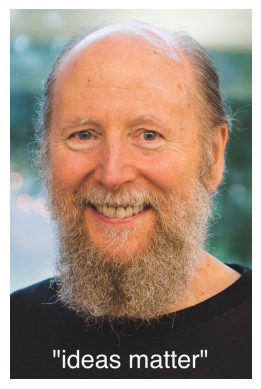

In [49]:
# image = Image.open("./nlp-with-transformers-main/images/optimusprime.jpg")
# image = Image.open("./nlp-with-transformers-main/images/doge.jpg")
image = Image.open("./nlp-with-transformers-main/images/sutton-head12.jpg")

plt.imshow(image)
plt.axis("off")
plt.show()

In [50]:
import torch

texts = ["a photo of a transformer", "a photo of man", "a photo of dog"]
inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)
with torch.no_grad():
    outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)
probs

tensor([[5.5426e-04, 9.9739e-01, 2.0555e-03]])

# 다음 목적지는?

### 허깅페이스 커뮤니티 이벤트에 참여하세요

### 자신만의 프로젝트를 만드세요

### 트렌스포머에 모델을 기여하세요

### 배운것을 블로그에 쓰세요